In [1]:
import sys
sys.path.append("../python/")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
#import bokeh.palettes
import _corner
import imp
imp.reload(_corner)
from _corner import corner
from scipy.stats import gaussian_kde
import pickle
from matplotlib.offsetbox import AnchoredText
import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population
from astropy.constants import R_jup, M_jup, M_sun, L_sun
from scipy.interpolate import interp1d, interp2d
from utils import temperature, heat, temperature_withDM
from scipy.stats import loguniform, chi2
from scipy.optimize import newton, brentq
import matplotlib.colors as colors

import sensitivity
imp.reload(sensitivity)
from sensitivity import sensitivity

import imp
import utils_plots
imp.reload(utils_plots)
from utils_plots import grid_sensitivity

from matplotlib import rc
rc('font', family='times new roman', size=22.)

In [4]:
np.random.seed(42)
# Number of simulated exoplanets
N = 10000

# galactocentric radius of simulated exoplanets
r_obs = loguniform.rvs(0.1, 8.178, size=N)

## load theoretical BD cooling model taken from Saumon & Marley '08 (fig 2)
age  = {}; logL = {}; L = {}; Teff = {}
M    = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

# TODO simplify by directly interpolating on heating/luminosity
for mass in M:
    data = np.genfromtxt("../data/evolution_models/SM08/saumon_marley_fig2_" + str(mass) + ".dat", 
                         unpack=True)
    age[mass]  = data[0]
    heat_int   = np.power(10, data[1])*L_sun.value
    Teff[mass] = temperature(heat_int, R_jup)
log_age  = np.linspace(6.1, 9.92, 10)
_log_age = []
_mass    = []
_teff    = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for lage in log_age:
        _log_age.append(lage)
        _mass.append(m)
        _teff.append(Teff_interp(lage))
# effective temperature (wo DM heating) vs log(age) and mass exoplanet
Teff_interp_2d = interp2d(_log_age, _mass, _teff)
del age, logL, L, M, Teff, _log_age, _mass, _teff

## Ages and masses of simulated BDs
log_ages = np.random.uniform(9., 9.92, N) # [yr] / [1-10 Gyr]
mass     = random_powerlaw(-0.6, N)
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#_, _, _ = ax.hist(mass, bins=40)
mass     = mass*M_jup/M_sun # [Msun]
# Mapping (mass, age) -> Teff -> internal heat flow (no DM)
heat_int = np.zeros(N)
Teff     = np.zeros(N)
for i in range(N):
    Teff[i]     = Teff_interp_2d(log_ages[i], mass[i])
    heat_int[i] = heat(Teff[i], R_jup.value)

In [5]:
rel_unc=0.05
Teff_obs = Teff + np.random.normal(loc=0, scale=(rel_unc*Teff), size=N)

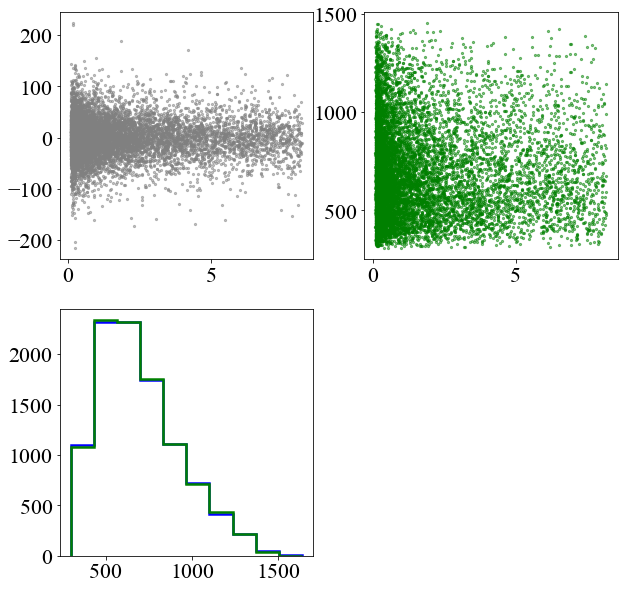

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].scatter(r_obs, Teff_obs-Teff, s=5, color="grey", alpha=0.5)
ax[0, 1].scatter(r_obs, Teff, s=5, color="green", alpha=0.5)

_, bins, _ = ax[1, 0].hist(Teff_obs, color="blue", histtype="step", linewidth=2.5)
_, _, _ = ax[1, 0].hist(Teff, bins=bins, color="green", histtype="step", linewidth=2.5)

ax[1, 1].remove()

In [6]:
Tobs = temperature_withDM(r_obs, heat_int, f=1, R=R_jup.value, 
                          M=mass*M_sun.value, parameters=[1, 20, 0.42])

Tobs_obs = Tobs + np.random.normal(loc=0, scale=(rel_unc*Tobs), size=N)

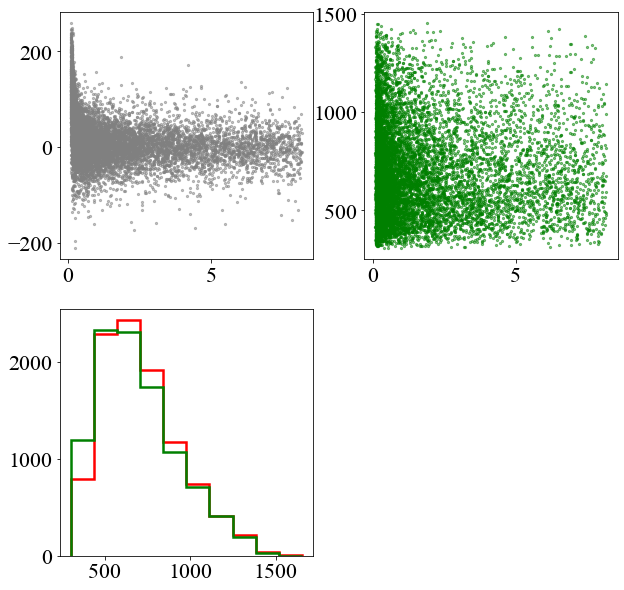

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].scatter(r_obs, Tobs_obs-Teff, s=5, color="grey", alpha=0.5)
ax[0, 1].scatter(r_obs, Teff, s=5, color="green", alpha=0.5)

_, bins, _ = ax[1, 0].hist(Tobs_obs, color="red", histtype="step", linewidth=2.5)
_, _, _ = ax[1, 0].hist(Teff, bins=bins, color="green", histtype="step", linewidth=2.5)

ax[1, 1].remove()

In [50]:
r_bins = np.logspace(np.log10(0.1), np.log10(8.178), 10)
mean_eff = []; mean_obs = []
std_eff = []; std_obs = []
_r = []

res_eff = Teff_obs - Teff
res_obs = Tobs_obs - Teff

for i in range(len(r_bins)-1):
    pos = np.where((r_obs > r_bins[i]) & (r_obs < r_bins[i+1]))
    #print(len(r_obs[pos]))
    mean_eff.append(np.mean(res_eff[pos])); std_eff.append(np.std(res_eff[pos]))
    mean_obs.append(np.mean(res_obs[pos])); std_obs.append(np.std(res_obs[pos]))
    _r.append(0.5*(r_bins[i] + r_bins[i+1]))

std_eff = np.array(std_eff)
std_obs = np.array(std_obs)

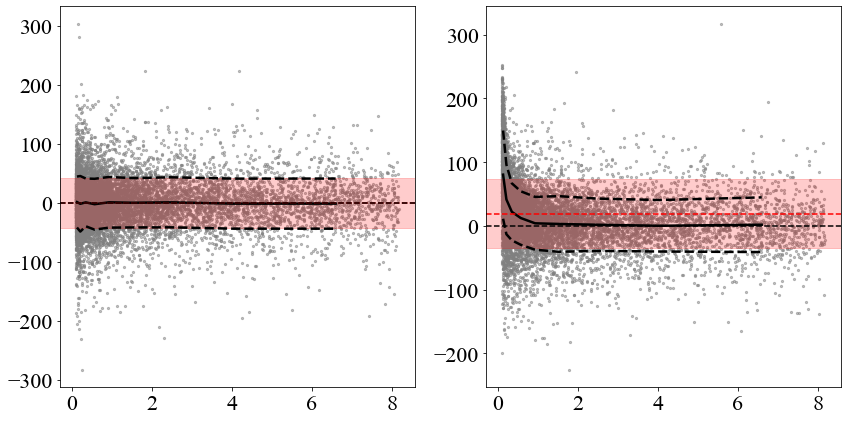

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))


ax[0].scatter(r_obs, Teff_obs-Teff, s=5, color="grey", alpha=0.5)
ax[0].plot(_r, mean_eff, color="k", lw=2.5)
ax[0].plot(_r, mean_eff + std_eff, color="k", lw=2.5, ls="--")
ax[0].plot(_r, mean_eff-std_eff, color="k", lw=2.5, ls="--")
ax[0].axhline(np.mean(res_eff), ls="--", color="r")
ax[0].axhspan(np.mean(res_eff)-np.std(res_eff), np.mean(res_eff)+np.std(res_eff), color="r", alpha=0.2)
ax[0].axhline(0, ls="--", color="k")

ax[1].scatter(r_obs, Tobs_obs-Teff, s=5, color="grey", alpha=0.5)
ax[1].plot(_r, mean_obs, color="k", lw=2.5)
ax[1].plot(_r, mean_obs+std_obs, color="k", lw=2.5, ls="--")
ax[1].plot(_r, mean_obs-std_obs, color="k", lw=2.5, ls="--")
ax[1].axhline(np.mean(res_obs), ls="--", color="r")
ax[1].axhspan(np.mean(res_obs)-np.std(res_obs), np.mean(res_obs)+np.std(res_obs), color="r", alpha=0.2)
ax[1].axhline(0, ls="--", color="k")

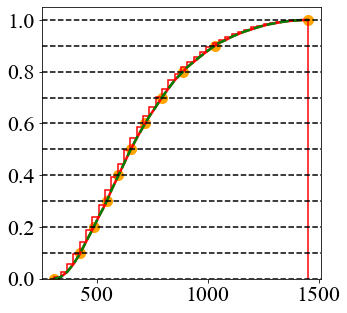

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

p, bins, _ = ax.hist(Teff, bins=40, density=True, histtype="step", linewidth=1.5, color="red", cumulative=True)
p = np.insert(p, 0, 0)
ax.plot(bins, p, color="red", lw=2.5)

p_interp = interp1d(bins, p)
ax.plot(bins, p_interp(bins), color="green", ls="--", lw=2.5)

def interp_find_x(x, y):
    return p_interp(x) - y

y_h = np.linspace(0, 1, 11)
bins_equal = []
for y in y_h:
    ax.axhline(y, ls="--", color="k")
    root = newton(interp_find_x, 400, args=(y, ))
    ax.scatter(root, y, s=100, color="orange")
    bins_equal.append(root)

In [70]:
def interp_find_x(x, y, p_interp):
    #print(x, y, p_interp(x), p_interp(x)-y)
    try:
        # return
        return p_interp(x) - y
    except:
        return np.inf

def sensitivity(Tobs, Teff, alpha=0.05):
    """
    Perform goodness-of-fit test and returns True/False if theretical cooling 
    models can/cannot explain observations
    """
    # Make number of counts histogram
    ## Calculate bins with equal probability

    p, bins, _ = ax[0].hist(Teff, bins=40, density=True, cumulative=True, histtype="step", linewidth=1.5, color="red")
    p          = np.insert(p, 0, 0)
    p    = np.insert(p, len(p), 1)
    bins = np.insert(bins, len(bins), bins[len(bins)-1]+1000)
    x0   = bins[1]
    p    = np.insert(p, 0, 0)
    bins = np.insert(bins, 0, 0)
    
    #print(bins, bins[-2], len(bins), len(p))
    #print(p)
    
    p_interp   = interp1d(bins, p)
    y_h        = np.linspace(0.1, 0.9, 9) # total number of bins = 10
    bins_equal = []
    bins_equal.append(x0)
    for y in y_h:
        root = brentq(interp_find_x, x0, bins[-1], args=(y, p_interp))
        """
        try: 
            #print(y, newton(interp_find_x, x0, args=(y, )))
            root = newton(interp_find_x, x0, args=(y, p_interp,))
        except:
            if y == y_h[-1]:
                #print(y)
                root = bins[-2]
            else:
                x0 = x0 + 50
                #print("except", y, newton(interp_find_x, x0, args=(y, )))
                root = newton(interp_find_x, x0, args=(y, p_interp, ))
        """
        ax[0].axhline(y, ls="--", color="k")
        ax[0].scatter(root, y, s=100, color="orange")
        
        x0 = root
        bins_equal.append(root)
    bins_equal.append(bins[-2])
    ax[0].scatter(bins[-2], 1., s=100, color="orange")
    try:
        # n_th = 0.10*nBDs (or similar)
        n_th, _ = np.histogram(Teff, bins=bins_equal) # theoretical counts
    except ValueError:
        print(bins_equal)
        sys.exit(-1)
    #print(n_th)
    n, _    = np.histogram(Tobs, bins=bins_equal)

    print(n_th)
    print(n)
    _chi2   = np.sum(np.power(n-n_th, 2)/n_th) 
    p_value = chi2.sf(_chi2, len(n)-1)
    print(_chi2, p_value)
    if p_value >= alpha:
        # return
        return 1, bins_equal
    else:
        # return
        return 0, bins_equal

In [50]:
from mock_generation import mock_population_sens
import glob

 # load theoretical BD cooling model - ATMO 2020
path  =  "../data/evolution_models/ATMO_2020_models/evolutionary_tracks/"
model = "ATMO_CEQ/"
path  = path + model
M     = []
age   = {}
Teff  = {}
files = glob.glob(path + "*.txt")
for file in files:
    data = np.genfromtxt(file, unpack=True)
    age[data[0][0]]  = data[1] # age [Gyr]
    Teff[data[0][0]] = data[2] # Teff [K]
    M.append(data[0][0])

_age   = np.linspace(1, 10, 100)
_age_i = []; _mass = []; _teff = []
# the first 5 masses do not have all values between 1 and 10 Gyr
M = np.sort(M)[5:-1] # further remove larger masses
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for _a in _age:
        _age_i.append(_a)
        _mass.append(m)
        _teff.append(Teff_interp(_a))
points = np.transpose(np.asarray([_age_i, _mass]))
values = np.asarray(_teff)

f=1; g=0.5; rs=20.
rel_unc=0.; relM=0.
Tobs3, Teff3 = mock_population_sens(1000, rel_unc, relM, points, values, f, g, rs)
Tobs4, Teff4 = mock_population_sens(10000, rel_unc, relM, points, values, f, g, rs)
Tobs5, Teff5 = mock_population_sens(100000, rel_unc, relM, points, values, f, g, rs)

In [71]:
bool3, bins_equal3 = sensitivity(Tobs3, Teff3)
bool4, bins_equal4 = sensitivity(Tobs4, Teff5)
bool5, bins_equal5 = sensitivity(Tobs4, Teff5)

print(bool3, bool4, bool5)

[ 67  93  98 105 101 102  98 101  99 100]
[ 68  91 103 116 100  99 100 107 100 100]
1.970908383432415 0.9919193305580036
[ 7180 10030 10066 10012  9979  9963 10025  9983 10043  9948]
[ 696 1063 1017 1023 1021 1009 1023  923 1037 1028]
78546.09137310694 0.0
[ 7180 10030 10066 10012  9979  9963 10025  9983 10043  9948]
[ 696 1063 1017 1023 1021 1009 1023  923 1037 1028]
78546.09137310694 0.0
1 0 0


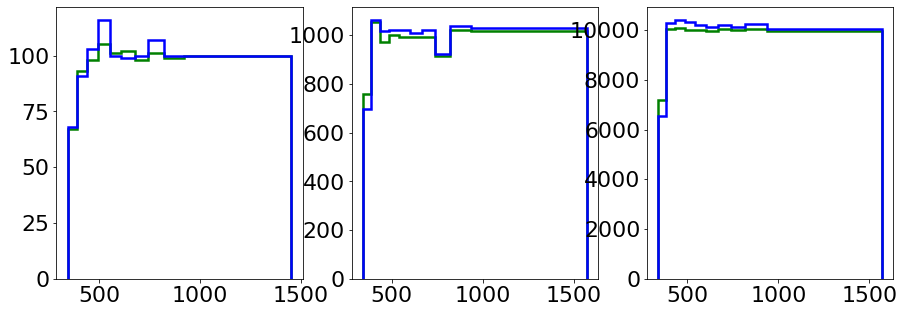

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

_, _, _ = ax[0].hist(Teff3, bins=bins_equal3, histtype="step", linewidth=2.5, color="green")
_, _, _ = ax[0].hist(Tobs3, bins=bins_equal3, histtype="step", linewidth=2.5, color="blue")

_, _, _ = ax[1].hist(Teff4, bins=bins_equal4, histtype="step", linewidth=2.5, color="green")
_, _, _ = ax[1].hist(Tobs4, bins=bins_equal4, histtype="step", linewidth=2.5, color="blue")

_, _, _ = ax[2].hist(Teff5, bins=bins_equal5, histtype="step", linewidth=2.5, color="green")
_, _, _ = ax[2].hist(Tobs5, bins=bins_equal5, histtype="step", linewidth=2.5, color="blue")

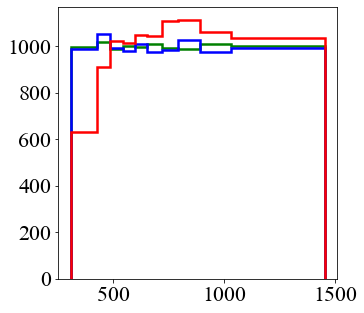

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

counts_th, _, _ = ax.hist(Teff, bins=bins_equal, histtype="step", linewidth=2.5, color="green")
counts_eff, _, _ = ax.hist(Teff_obs, bins=bins_equal, histtype="step", linewidth=2.5, color="blue")
counts_obs, _, _ = ax.hist(Tobs_obs, bins=bins_equal, histtype="step", linewidth=2.5, color="red")

In [26]:
import glob

# load theoretical BD cooling model - ATMO 2020
path  =  "../data/evolution_models/ATMO_2020_models/evolutionary_tracks/"
model = "ATMO_CEQ/"
path  = path + model
M     = []
age   = {}
Teff  = {}
files = glob.glob(path + "*.txt")
for file in files:
    data = np.genfromtxt(file, unpack=True)
    age[data[0][0]]  = data[1] # age [Gyr]
    Teff[data[0][0]] = data[2] # Teff [K]
    M.append(data[0][0])

_age   = np.linspace(1, 10, 100)
_age_i = []; _mass = []; _teff = []
# the first 5 masses do not have all values between 1 and 10 Gyr
M = np.sort(M)[5:-10] # further remove larger masses
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for _a in _age:
        _age_i.append(_a)
        _mass.append(m)
        _teff.append(Teff_interp(_a))
points = np.transpose(np.asarray([_age_i, _mass]))
values = np.asarray(_teff)

[   0.          315.77144141  346.48183355  377.19222569  407.90261782
  438.61300996  469.3234021   500.03379424  530.74418638  561.45457852
  592.16497066  622.87536279  653.58575493  684.29614707  715.00653921
  745.71693135  776.42732349  807.13771563  837.84810777  868.5584999
  899.26889204  929.97928418  960.68967632  991.40006846 1022.1104606
 1052.82085274 1083.53124487 1114.24163701 1144.95202915 1175.66242129
 1206.37281343 1237.08320557 1267.79359771 1298.50398985 1329.21438198
 1359.92477412 1390.63516626 1421.3455584  1452.05595054 1482.76634268
 1513.47673482 1544.18712695 2544.18712695] 1544.1871269548146 43 43
[0.     0.     0.0282 0.0793 0.1408 0.1976 0.2556 0.3178 0.3732 0.4262
 0.475  0.526  0.571  0.6191 0.663  0.705  0.7489 0.7869 0.8239 0.8551
 0.8799 0.9001 0.9153 0.9298 0.9407 0.9492 0.9576 0.9641 0.9692 0.9739
 0.9782 0.9828 0.9865 0.9903 0.9925 0.9953 0.9968 0.9975 0.9985 0.999
 0.9996 1.     1.    ]


(0,
 [346.48183354678144,
  387.52889425895165,
  439.88378480990104,
  491.2452897374136,
  546.2732148564526,
  607.219084449586,
  672.1013759734017,
  742.0609322853315,
  818.0108544650791,
  929.8272525372131,
  1544.1871269548146])

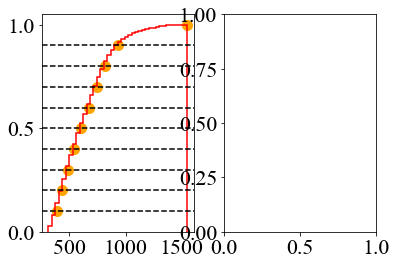

In [27]:
from mock_generation import mock_population_sens

fig, ax = plt.subplots(1, 2)

Tobs, Teff = mock_population_sens(10000, 0.05, 0., points, values, 1., 0.5)
sensitivity(Tobs, Teff, alpha=0.05)

====== nBDS=10000, rel_unc=0.05, f=0.1, gamma=0.2


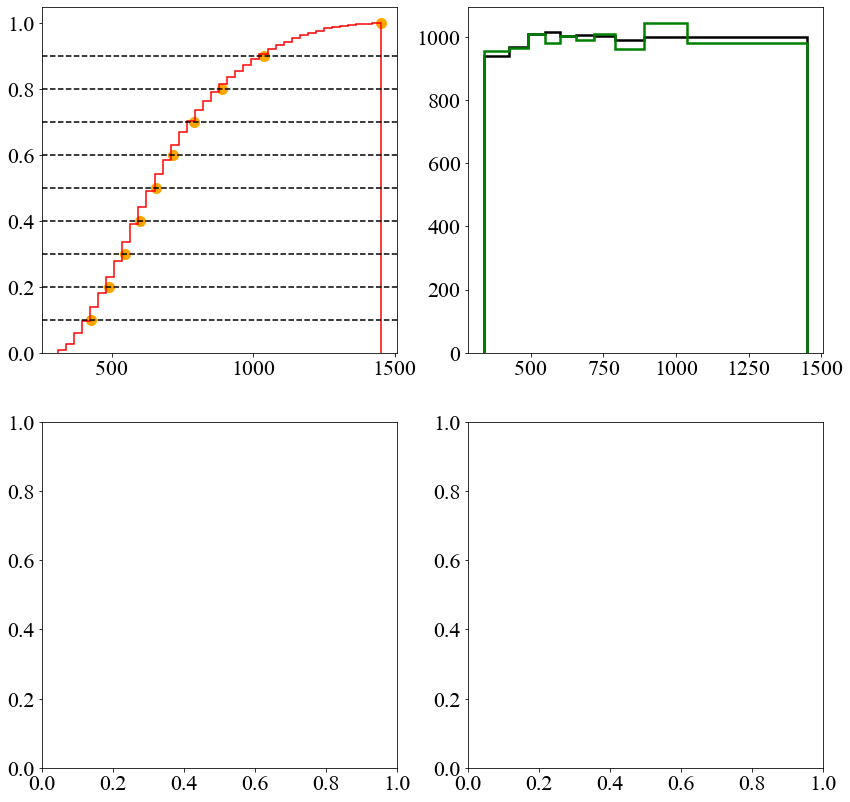

In [124]:
nBDs = 10000
rel_unc = 0.05
f     = [0.1]
gamma = [0.2]
rank  = 1
fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for _f in f:
    for _g in gamma:
        print("====== nBDS=%i, rel_unc=%.2f, f=%.1f, gamma=%.1f" 
                %(nBDs, rel_unc, _f, _g))
        _bool = np.ones(rank)*100
        for i in range(rank):
            _, Tobs, _, Teff, _, _ = mock_population(nBDs, rel_unc, 0., _f, _g)
            _bool[i], bins_equal = sensitivity(Tobs, Teff)
            if i==0 and _bool[i] == 1:
                counts_th, _, _ = ax[0, 1].hist(Teff, bins=bins_equal, histtype="step", linewidth=2.5, color="k")
                counts_obs, _, _ = ax[0, 1].hist(Tobs, bins=bins_equal, histtype="step", linewidth=2.5, color="green")
            if _bool[i]==0:
                counts_th, _, _ = ax[1, 1].hist(Teff, bins=bins_equal, histtype="step", linewidth=2.5, color="k")
                counts_obs, _, _ = ax[1, 1].hist(Tobs, bins=bins_equal, histtype="step", linewidth=2.5, color="green")
                break
        #print("Accepted H0 : %i" %int(np.sum(_bool)))
        #print("Rejected H0 : %i" %(len(_bool)-int(np.sum(_bool))))
   

# PLOTS

In [89]:
import utils_plots
imp.reload(utils_plots)
from utils_plots import sensitivity_grid

def plot_sensitivity_grid(filepath):
    fig, axes = plt.subplots(2, 3, figsize=(14, 10), sharex=True, sharey=True)
    
    _nBDs = [100, 1000, 10000]
    _rel_unc = [0.05, 0.1]
    nBDs    = []
    rel_unc = []

    for rel in _rel_unc:
        for n in _nBDs:
            nBDs.append(n)
            rel_unc.append(rel)
        
    for i, ax in enumerate(axes.flat):
        
        sensitivity_grid(filepath, nBDs[i], rel_unc[i], ax=ax)
        
        if i==0 or i==3:
            ax.set_ylabel(r"$\gamma$")
        if i >= 3:
            ax.set_xlabel(r"$f$")
        
        text_box = AnchoredText((r"N=%i, $\sigma_T$=%i" %(nBDs[i], int(rel_unc[i]*100)) + "$\%$"),
                                bbox_to_anchor=(0., 0.99),
                                bbox_transform=ax.transAxes, loc='lower left', pad=0.04, prop=dict(size=20))
        
        plt.setp(text_box.patch, facecolor="white")
        ax.add_artist(text_box)
        
        plt.yticks([0.2, 0.6, 1.0, 1.4, 1.8], ['0.2', '0.6', '1', '1.4', '1.8'])
        plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9], ['0.1', '0.3', '0.5', '0.7', '0.9'])
    
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2.5)
    
    fig.subplots_adjust(wspace=0.08)
    fig.savefig("../Figs/ex1_sensitivity.pdf")

In [4]:
import utils_plots
imp.reload(utils_plots)
from utils_plots import sensitivity_grid

def plot_sensitivity_grid(filepath):
    fig, axes = plt.subplots(2, 4, figsize=(19, 10), sharex=True, sharey=True)
    
    _nBDs    = [100, 10000]
    _rel_unc = [0.05, 0.1]
    _relM    = [0.10, 0.20]
    nBDs     = []
    rel_unc  = []
    relM     = []
    
    for n in _nBDs:
        for rel in _rel_unc:
            for rM in _relM:
                nBDs.append(n)
                rel_unc.append(rel)
                relM.append(rM)
        
    for i, ax in enumerate(axes.flat):
        
        sensitivity_grid(filepath, nBDs[i], rel_unc[i], relM[i], ax=ax)
        
        if i==0 or i==4:
            ax.set_ylabel(r"$\gamma$")
        if i >= 4:
            ax.set_xlabel(r"$f$")
        
        text_box = AnchoredText((r"N=%i, $\sigma_T$=%i" %(nBDs[i], int(rel_unc[i]*100)) + "$\%, $" 
                                + "$\sigma_M$=%i" %(int(relM[i]*100)) + "$\%$"),
                                bbox_to_anchor=(0., 0.99),
                                bbox_transform=ax.transAxes, loc='lower left', pad=0.04, prop=dict(size=20))
        
        plt.setp(text_box.patch, facecolor="white")
        ax.add_artist(text_box)
        
        plt.yticks([0.2, 0.6, 1.0, 1.4, 1.8], ['0.2', '0.6', '1', '1.4', '1.8'])
        plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9], ['0.1', '0.3', '0.5', '0.7', '0.9'])
    
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2.5)
    
    fig.subplots_adjust(wspace=0.08)
    fig.savefig("../Figs/ex3_sensitivity.pdf")

In [8]:
import utils_plots
imp.reload(utils_plots)
from utils_plots import sensitivity_grid

def plot_sensitivity_grid(filepath, exercise):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    
    _nBDs    = [100, 1000]
    _rel_unc = [0.1]
    _relM    = [0.10]
    nBDs     = []
    rel_unc  = []
    relM     = []
    
    for n in _nBDs:
        for rel in _rel_unc:
            for rM in _relM:
                nBDs.append(n)
                rel_unc.append(rel)
                relM.append(rM)
        
    for i, ax in enumerate(axes.flat):
        
        sensitivity_grid(filepath, nBDs[i], rel_unc[i], relM[i], ax=ax)
        
        if i==0:
            ax.set_ylabel(r"$\gamma$")
        ax.set_xlabel(r"$f$")
        
        text_box = AnchoredText((r"N=%i, $\sigma_T$=%i" %(nBDs[i], int(rel_unc[i]*100)) + "$\%, $" 
                                + "$\sigma_M$=%i" %(int(relM[i]*100)) + "$\%$"),
                                bbox_to_anchor=(0., 0.99),
                                bbox_transform=ax.transAxes, loc='lower left', pad=0.04, prop=dict(size=20))
        
        plt.setp(text_box.patch, facecolor="white")
        ax.add_artist(text_box)
        
        plt.yticks([0.2, 0.6, 1.0, 1.4, 1.8], ['0.2', '0.6', '1', '1.4', '1.8'])
        plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9], ['0.1', '0.3', '0.5', '0.7', '0.9'])
    
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2.5)
    
    fig.subplots_adjust(wspace=0.08)
    fig.savefig("../Figs/" + exercise + "_sensitivity.pdf")

# Final run

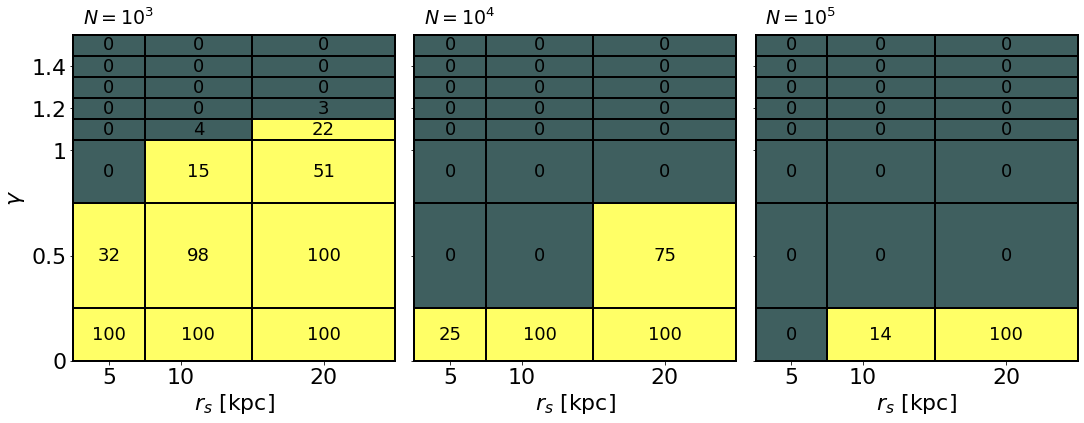

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

path = "/home/mariacst/exoplanets/results/"
grid_sensitivity(path, 1000, 0., 0., "ex3", ax[0], True, True)
grid_sensitivity(path, 10000, 0., 0., "ex3", ax[1], False, True)
grid_sensitivity(path, 100000, 0., 0., "ex3", ax[2], False, True)

fig.subplots_adjust(wspace=0.06)
fig.savefig("../../Figs/sensitivity_ex3.pdf", bbox_inches="tight")

# GC analysis

findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


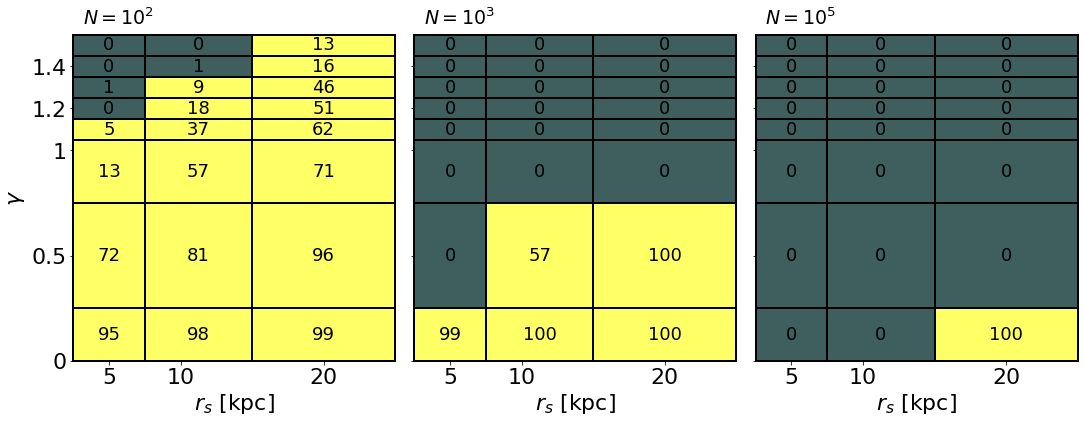

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

path = "/home/mariacst/exoplanets/results/"
grid_sensitivity(path, 100, 0., 0., "ex4", ax[0], True, True)
grid_sensitivity(path, 1000, 0., 0., "ex4", ax[1], False, True)
grid_sensitivity(path, 100000, 0., 0., "ex4", ax[2], False, True)

fig.subplots_adjust(wspace=0.06)
fig.savefig("../../Figs/sensitivity_ex4.pdf", bbox_inches="tight")

## Effect of DM velocities

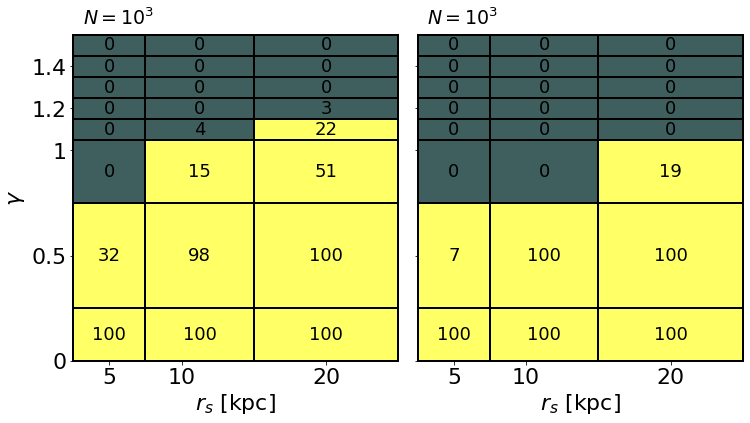

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

path = "/home/mariacst/exoplanets/results/"
grid_sensitivity(path, 1000, 0., 0., "ex3", ax[0], True, True)
grid_sensitivity(path, 1000, 0., 0., "ex3v", ax[1], False, True)

fig.subplots_adjust(wspace=0.06)
#fig.savefig("../../results/Figs/DMvelocity_sensitivity.pdf", bbox_inches="tight")

findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


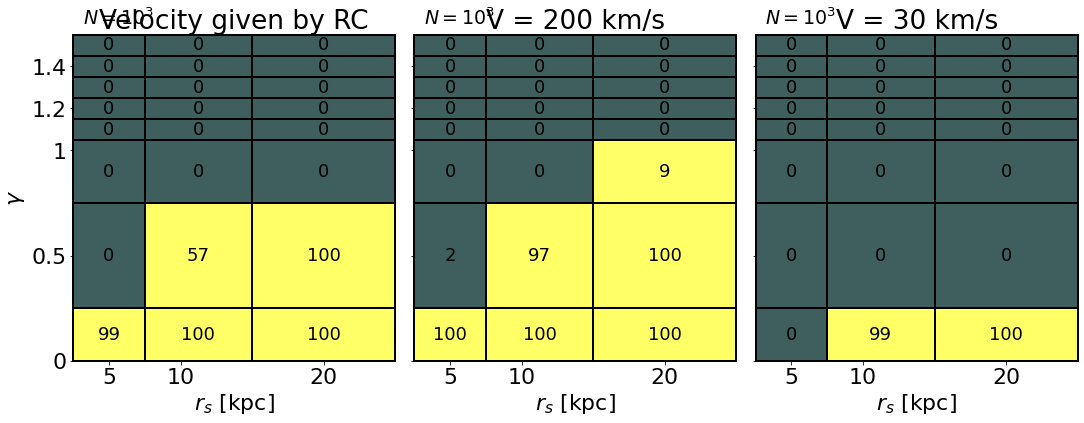

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

path = "/home/mariacst/exoplanets/results/GC/"
grid_sensitivity(path, 1000, 0., 0., "ex4", ax[0], True, True)
path = "/home/mariacst/exoplanets/results/velocity/"
grid_sensitivity(path, 1000, 0., 0., "ex6", ax[1], False, True)
grid_sensitivity(path, 1000, 0., 0., "ex7", ax[2], False, True)

ax[0].set_title("Velocity given by RC")
ax[1].set_title("V = 200 km/s")
ax[2].set_title("V = 30 km/s")

fig.subplots_adjust(wspace=0.06)

## GC + Tmin

In [2]:
from matplotlib.offsetbox import AnchoredText

findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['times new roman'] not found. Falling back to DejaVu Sans.


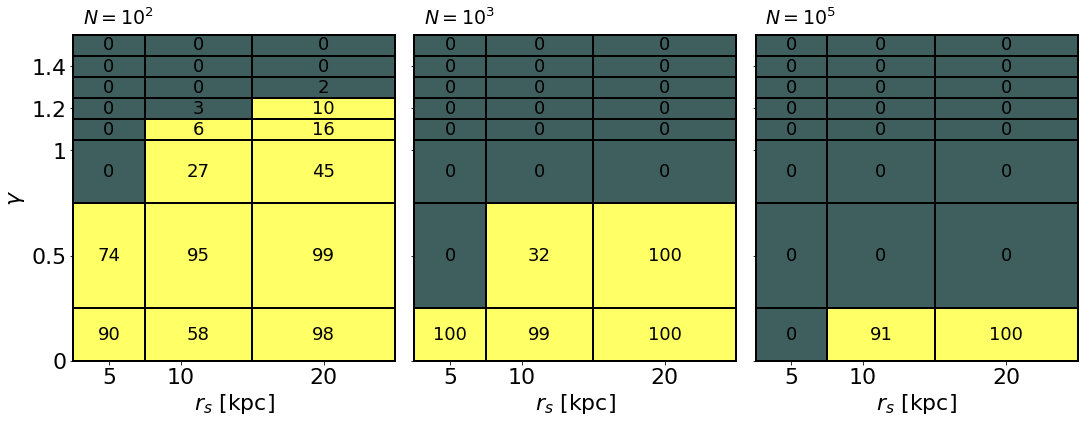

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

path = "/home/mariacst/exoplanets/results/Tmin/"
grid_sensitivity(path, 100, 0., 0., "ex5", ax[0], True, True)
grid_sensitivity(path, 1000, 0., 0., "ex5", ax[1], False, True)
grid_sensitivity(path, 100000, 0., 0., "ex5", ax[2], False, True)

fig.subplots_adjust(wspace=0.06)

**Comparison GC versus GC + Tmin**

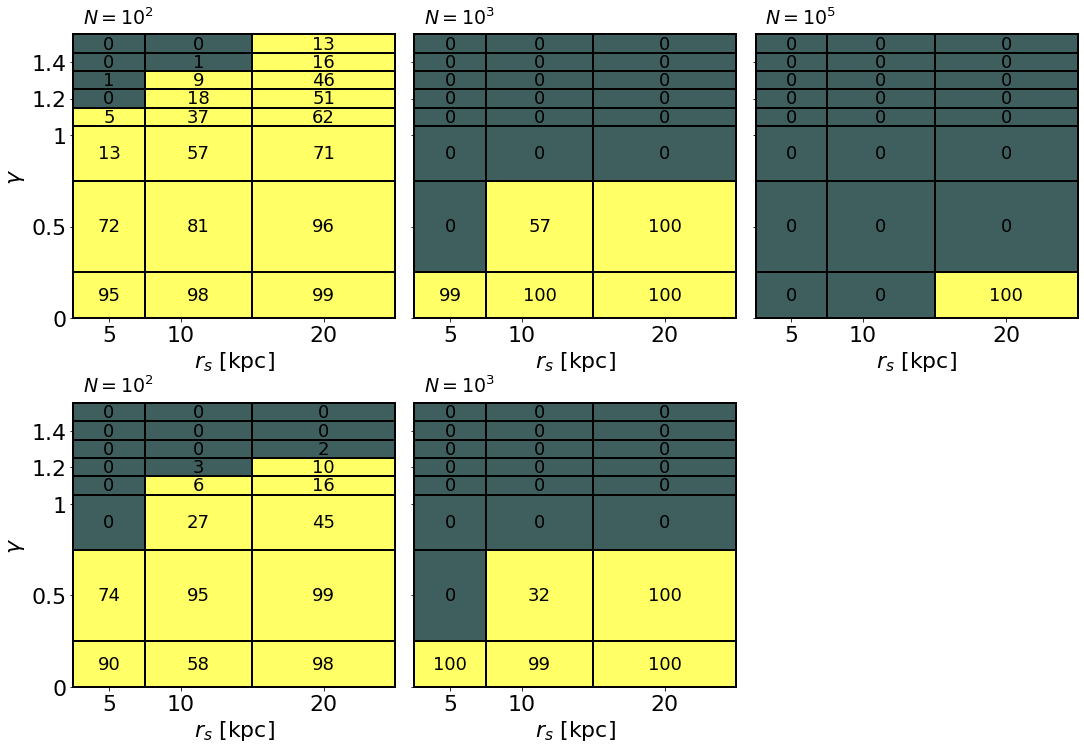

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

path = "/home/mariacst/exoplanets/results/GC/"
grid_sensitivity(path, 100, 0., 0., "ex4", ax[0, 0], True, True)
grid_sensitivity(path, 1000, 0., 0., "ex4", ax[0, 1], False, True)
grid_sensitivity(path, 100000, 0., 0., "ex4", ax[0, 2], False, True)

path = "/home/mariacst/exoplanets/results/Tmin/"
grid_sensitivity(path, 100, 0., 0., "ex5", ax[1, 0], True, True)
grid_sensitivity(path, 1000, 0., 0., "ex5", ax[1, 1], False, True)
ax[1, 2].set_visible(False)

fig.subplots_adjust(wspace=0.06, hspace=0.3)

## Investigating why the sensitivity for GC + Tmin analysis seems better than for GC alone

In [37]:
from mock_generation import mock_population_sens

In [38]:
# load theoretical BD cooling model - ATMO 2020
path  =  "./data/"
data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]
# ----------------
nBDs = 100; relT = 0.; relM = 0.
f = 1.; _g = 1.5; _rs=20.

In [107]:
def interp_find_x(x, y, p_interp):
    try:
        # return
        return p_interp(x) - y
    except:
        return np.inf

def sensitivity(Tobs, Teff, bins_equal, alpha=0.05):
    """
    Perform goodness-of-fit test and returns True/False if theretical cooling 
    models can/cannot explain observations
    """
    n_th, _ = np.histogram(Teff, bins=bins_equal) # theoretical counts
    n, _    = np.histogram(Tobs, bins=bins_equal)

    _chi2   = np.sum(np.power(n-n_th, 2)/n_th) # observed counts
    p_value = chi2.sf(_chi2, len(n)-1)
    #print(p_value)
    if p_value >= alpha:
        # return
        return 1
    else:
        # return
        return 0
    
def hypothesis_testing(nBDs, rel_unc, relM, points, values, f, _g, _rs, Tmin=0., v=None, rank=100):
            print("====== nBDS=%i, rel_unc=%.2f, relM=%.2f, rs=%.1f, gamma=%.1f" 
                    %(nBDs, rel_unc, relM, _rs, _g))
            _bool = np.ones(rank)*100
            res   = []
            for i in range(rank):
                Tobs, Teff = mock_population_sens(nBDs, rel_unc, relM, points, 
                                                  values, f, _g, _rs, 
                                                  Tmin=Tmin, v=v)
                if i==0:
                    try:
                        ## Calculate bins with equal probability
                        p, bins, _ = plt.hist(Teff,bins=40, density=True, cumulative=True)
                        p          = np.insert(p, 0, 0)
                        p    = np.insert(p, len(p), 1)
                        bins = np.insert(bins, len(bins), bins[len(bins)-1]+1000)
                        x0   = bins[1]
                        p    = np.insert(p, 0, 0)
                        bins = np.insert(bins, 0, 0)

                        p_interp   = interp1d(bins, p)
                        y_h        = np.linspace(0.1, 0.9, 9)# total number bins = 10
                        bins_equal = []
                        bins_equal.append(x0)
                        for y in y_h:
                            root = brentq(interp_find_x, x0, bins[-1], 
                                      args=(y, p_interp))
                            x0 = root
                            bins_equal.append(root)
                        bins_equal.append(bins[-2])
                    except:
                        Tobs, Teff = mock_population_sens(nBDs, rel_unc, relM, 
                                                  points, values, f, _g, _rs, 
                                                  Tmin=Tmin, v=v)
                        ## Calculate bins with equal probability
                        p, bins, _ = plt.hist(Teff,bins=40,density=True,
                                          cumulative=True)
                        p          = np.insert(p, 0, 0)
                        p    = np.insert(p, len(p), 1)
                        bins = np.insert(bins, len(bins), bins[len(bins)-1]+1000)
                        x0   = bins[1]
                        p    = np.insert(p, 0, 0)
                        bins = np.insert(bins, 0, 0)

                        p_interp   = interp1d(bins, p)
                        y_h        = np.linspace(0.1, 0.9, 9)# total number bins = 10
                        bins_equal = []
                        bins_equal.append(x0)
                        for y in y_h:
                            root = brentq(interp_find_x, x0, bins[-1], 
                                      args=(y, p_interp))
                            x0 = root
                            bins_equal.append(root)
                        bins_equal.append(bins[-2])

                _bool[i], _res = sensitivity(Tobs, Teff, bins_equal)
                res.append(_res)
            print("Accepted H0 : %i" %int(np.sum(_bool)))
            print("Rejected H0 : %i" %(len(_bool)-int(np.sum(_bool))))
            # return
            return int(np.sum(_bool)), bins_equal, res

====== nBDS=100, rel_unc=0.00, relM=0.00, rs=20.0, gamma=1.5


/home/mariacst/exoplanets/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/mariacst/exoplanets/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


Accepted H0 : 8
Rejected H0 : 92
====== nBDS=100, rel_unc=0.00, relM=0.00, rs=20.0, gamma=1.5
Accepted H0 : 0
Rejected H0 : 100


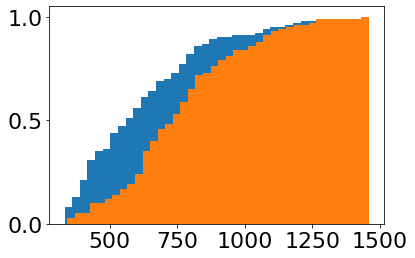

In [83]:
np.random.seed(42)
accepted, bins, res = hypothesis_testing(nBDs, relT, relM, points, values, f, _g, _rs, Tmin=0., v=None, rank=100)
np.random.seed(42)
accepted_Tmin, bins_Tmin, res_Tmin = hypothesis_testing(nBDs, relT, relM, points, values, f, _g, _rs, Tmin=650., v=None, rank=100)

In [86]:
Tx = []
Tx_Tmin = []
for i in range(len(bins)-1):
    Tx.append((bins[i] + bins[i+1])*0.5)
    Tx_Tmin.append((bins_Tmin[i] + bins_Tmin[i+1])*0.5)

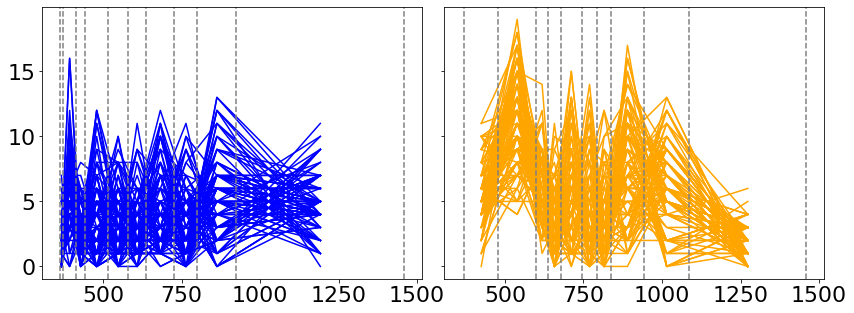

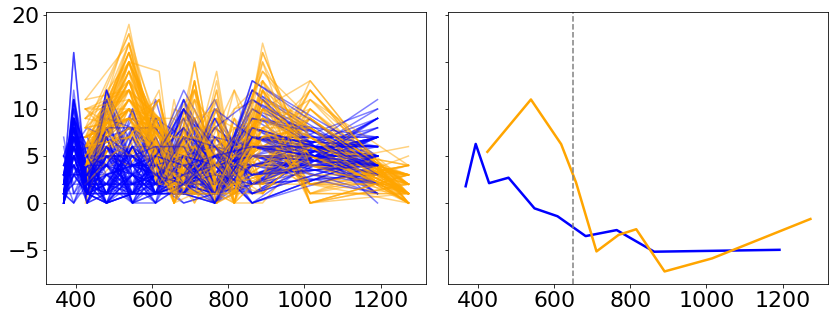

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True, sharex=True)
for i in range(100):
    ax[0].plot(Tx, np.abs(res[i]), color="blue")
    ax[1].plot(Tx_Tmin, np.abs(res_Tmin[i]), color="orange")
for i in range(len(bins)):
    ax[0].axvline(bins[i], ls="--", color="grey")
    ax[1].axvline(bins_Tmin[i], ls="--", color="grey")
fig.subplots_adjust(wspace=0.06)


res = np.array(res)
res_Tmin = np.array(res_Tmin)
res_m = []
res_m_Tmin = []
for i in range(10):
    res_m.append(np.mean(res[:, i]))
    res_m_Tmin.append(np.mean(res_Tmin[:, i]))

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)
for i in range(100):
    ax[0].plot(Tx, np.abs(res[i]), color="blue", alpha=0.5)
    ax[0].plot(Tx_Tmin, np.abs(res_Tmin[i]), color="orange", alpha=0.5)
ax[1].plot(Tx, res_m, color="blue", lw=2.5)
ax[1].plot(Tx_Tmin, res_m_Tmin, color="orange", lw=2.5)
ax[1].axvline(650., color="grey", ls="--")
#for i in range(len(bins)):
#    ax[1].axvline(bins[i], ls="--", color="blue")
#    ax[1].axvline(bins_Tmin[i], ls="--", color="orange")
fig.subplots_adjust(wspace=0.06)

In [106]:
np.random.seed(42)
Tobs, Teff = mock_population_sens(nBDs, relT, relM, points, values, f, _g, _rs,  Tmin=0, v=None)
np.random.seed(42)
Tobs_Tmin, Teff_Tmin = mock_population_sens(nBDs, relT, relM, points, values, f, _g, _rs,  Tmin=650., v=None)

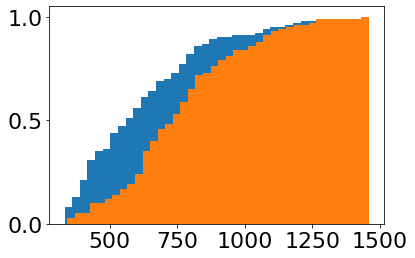

In [108]:
def sensitivity(Tobs, Teff, alpha=0.05):
    """
    Perform goodness-of-fit test and returns True/False if theretical cooling 
    models can/cannot explain observations
    """
    # Make number of counts histogram

    ## Calculate bins with equal probability
    p, bins, _ = plt.hist(Teff, bins=40, density=True, cumulative=True)
    p          = np.insert(p, 0, 0)
    p    = np.insert(p, len(p), 1)
    bins = np.insert(bins, len(bins), bins[len(bins)-1]+1000)
    x0   = bins[1]
    p    = np.insert(p, 0, 0)
    bins = np.insert(bins, 0, 0)

    p_interp   = interp1d(bins, p)
    y_h        = np.linspace(0.1, 0.9, 9) # total number of bins = 10
    bins_equal = []
    bins_equal.append(x0)
    for y in y_h:
        root = brentq(interp_find_x, x0, bins[-1], args=(y, p_interp))
        x0 = root
        bins_equal.append(root)
    bins_equal.append(bins[-2])

    n_th, _ = np.histogram(Teff, bins=bins_equal) # theoretical counts
    n, _    = np.histogram(Tobs, bins=bins_equal)

    _chi2   = np.sum(np.power(n-n_th, 2)/n_th) # observed counts
    p_value = chi2.sf(_chi2, len(n)-1)
    #print(p_value)
    if p_value >= alpha:
        # return
        return 1, bins_equal
    else:
        # return
        return 0, bins_equal
    
result, bins = sensitivity(Tobs, Teff)
result_Tmin, bins_Tmin = sensitivity(Tobs_Tmin, Teff_Tmin)

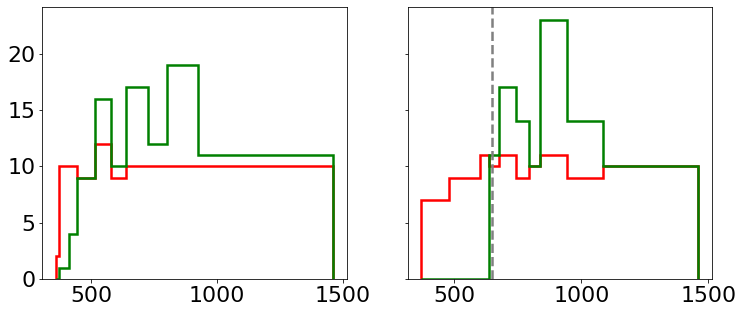

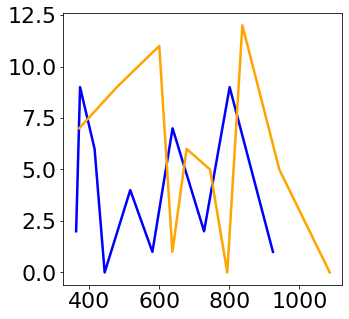

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

counts, _, _ = ax[0].hist(Teff, bins=bins, histtype="step", color="red", lw=2.5)
counts1, _, _ = ax[0].hist(Tobs, bins=bins, histtype="step", color="green", lw=2.5)

counts_Tmin, _, _ = ax[1].hist(Teff_Tmin, bins=bins_Tmin, histtype="step", color="red", lw=2.5)
counts1_Tmin, _, _ = ax[1].hist(Tobs_Tmin, bins=bins_Tmin, histtype="step", color="green", lw=2.5)
ax[1].axvline(650., color="grey", ls="--", lw=2.5)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(bins[:-1], np.abs(counts-counts1), color="blue", lw=2.5)
ax.plot(bins_Tmin[:-1], np.abs(counts_Tmin-counts1_Tmin), color="orange", lw=2.5)

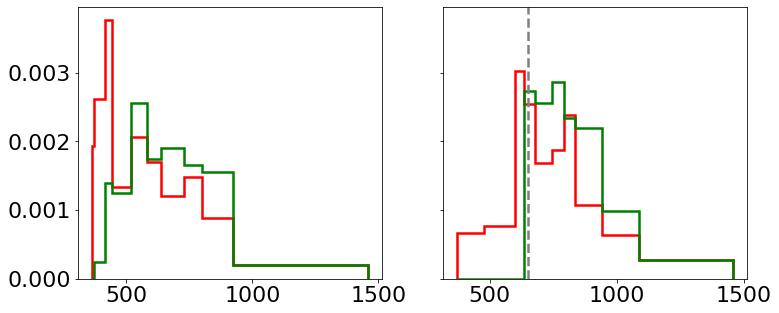

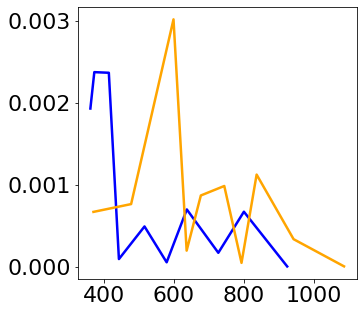

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

counts, _, _ = ax[0].hist(Teff, bins=bins, histtype="step", color="red", lw=2.5, density=True)
counts1, _, _ = ax[0].hist(Tobs, bins=bins, histtype="step", color="green", lw=2.5, density=True)

counts_Tmin, _, _ = ax[1].hist(Teff_Tmin, bins=bins_Tmin, histtype="step", color="red", lw=2.5, density=True)
counts1_Tmin, _, _ = ax[1].hist(Tobs_Tmin, bins=bins_Tmin, histtype="step", color="green", lw=2.5, density=True)
ax[1].axvline(650., color="grey", ls="--", lw=2.5)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(bins[:-1], np.abs(counts-counts1), color="blue", lw=2.5)
ax.plot(bins_Tmin[:-1], np.abs(counts_Tmin-counts1_Tmin), color="orange", lw=2.5)

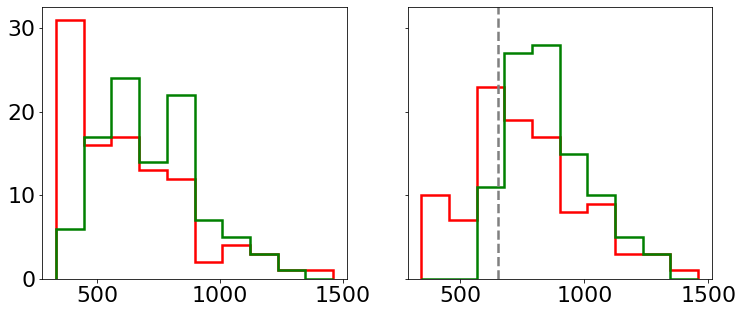

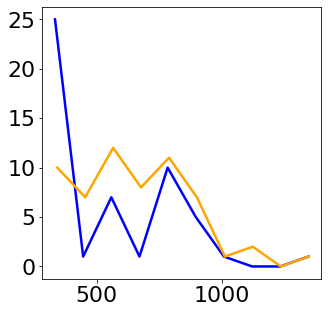

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

counts, bins1, _ = ax[0].hist(Teff, histtype="step", color="red", lw=2.5)
counts1, _, _ = ax[0].hist(Tobs, bins=bins1, histtype="step", color="green", lw=2.5)

counts_Tmin, bins_Tmin1, _ = ax[1].hist(Teff_Tmin, histtype="step", color="red", lw=2.5)
counts1_Tmin, _, _ = ax[1].hist(Tobs_Tmin, bins=bins_Tmin1, histtype="step", color="green", lw=2.5)
ax[1].axvline(650., color="grey", ls="--", lw=2.5)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(bins1[:-1], np.abs(counts-counts1), color="blue", lw=2.5)
ax.plot(bins_Tmin1[:-1], np.abs(counts_Tmin-counts1_Tmin), color="orange", lw=2.5)